# 数据集选用 Microsoft 资讯推荐 
# 1.获取数据

In [1]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [2]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [3]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

['entity_embedding.vec',
 'behaviors.tsv',
 'news.tsv',
 'relation_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip']

In [4]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behavior_data = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
behavior_data

,impression_id,user_id,time,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...
...,...,...,...,...,...
73147,73148,U77536,11/15/2019 8:40:16 PM,N28691 N8845 N58434 N37120 N22185 N60033 N4702...,N496-0 N35159-0 N59856-0 N13270-0 N47213-0 N26...
73148,73149,U56193,11/15/2019 1:11:26 PM,N4705 N58782 N53531 N46492 N26026 N28088 N3109...,N49285-0 N31958-0 N55237-0 N42844-0 N29862-0 N...
73149,73150,U16799,11/15/2019 3:37:06 PM,N40826 N42078 N15670 N15295 N64536 N46845 N52294,N7043-0 N512-0 N60215-1 N45057-0 N496-0 N37055...
73150,73151,U8786,11/15/2019 8:29:26 AM,N3046 N356 N20483 N46107 N44598 N18693 N8254 N...,N23692-0 N19990-0 N20187-0 N5940-0 N13408-0 N3...


In [5]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news_data = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
news_data

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
...,...,...,...,...,...,...,...,...
42411,N63550,lifestyle,lifestyleroyals,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,https://assets.msn.com/labs/mind/BBWyynu.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...",[]
42412,N30345,entertainment,entertainment-celebrity,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,https://assets.msn.com/labs/mind/BBWyz7N.html,[],"[{""Label"": ""Kate Hudson"", ""Type"": ""P"", ""Wikida..."
42413,N30135,news,newsgoodnews,Tennessee judge holds lawyer's baby as he swea...,Tennessee Court of Appeals Judge Richard Dinki...,https://assets.msn.com/labs/mind/BBWyzI8.html,"[{""Label"": ""Tennessee"", ""Type"": ""G"", ""Wikidata...","[{""Label"": ""Tennessee Court of Appeals"", ""Type..."
42414,N44276,autos,autossports,Best Sports Car Deals for October,NaN,https://assets.msn.com/labs/mind/BBy5rVe.html,"[{""Label"": ""Peugeot RCZ"", ""Type"": ""V"", ""Wikida...",[]


In [6]:
# The entity_embedding.vec file contains the 100-dimensional embeddings
# of the entities learned from the subgraph by TransE method.
# The first column is the ID of entity, and the other columns are the embedding vector values.
entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,'vector']].rename(columns={0: "entity"})
entity_embedding

,entity,vector
0,Q34433,"[0.017808, -0.073256, 0.102521, -0.059926, -0...."
1,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
2,Q56037,"[0.02155, -0.044888, -0.027872, -0.128843, 0.0..."
3,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
4,Q39631,"[-0.093106, -0.052002, 0.020556, -0.020801, 0...."
...,...,...
22888,Q278846,"[0.042413, 0.021957, 0.072414, -0.068437, 0.02..."
22889,Q54621949,"[-0.018299, -0.048378, -0.021645, -0.079743, 0..."
22890,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
22891,Q54862508,"[-0.052323, -0.078029, -0.060925, -0.052536, 0..."


In [7]:
# The relation_embedding.vec file contains the 100-dimensional embeddings
# of the relations learned from the subgraph by TransE method.
# The first column is the ID of relation, and the other columns are the embedding vector values.
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector']].rename(columns={0: "relation"})
relation_embedding

,relation,vector
0,P31,"[-0.073467, -0.132227, 0.034173, -0.032769, 0...."
1,P21,"[-0.078436, 0.108589, -0.049429, -0.131355, 0...."
2,P106,"[-0.052137, 0.052444, -0.019886, -0.152309, 0...."
3,P735,"[-0.051398, 0.056219, 0.068029, -0.137717, -0...."
4,P108,"[0.091231, 0.022526, 0.059349, -0.141853, 0.03..."
...,...,...
1086,P1897,"[-0.019021, 0.001183, -0.009602, -0.040833, -0..."
1087,P3776,"[-0.018365, 0.028526, -0.025934, 0.032296, -0...."
1088,P1194,"[-0.026819, 0.003231, -0.011298, -0.015206, 0...."
1089,P2502,"[0.003554, -0.041121, -0.010559, -0.037862, -0..."


In [8]:
shutil.rmtree(temp_dir)

# 2.数据预处理

In [9]:
import pandas as pd

# 处理 behavior_data
def preprocess_behavior_data(behavior_data):
    # 删除空值
    behavior_data.dropna(inplace=True)
    # 删除异常值
    behavior_data = behavior_data[behavior_data['impression_id'].notnull() &
                                  behavior_data['user_id'].str.startswith('U')]
    return behavior_data

# 处理 news_data
def preprocess_news_data(news_data):
    # 删除空值
    news_data.dropna(inplace=True)
    # 删除异常值
    news_data = news_data[news_data['id'].str.startswith('N')]
    return news_data

# 打印处理后的 behavior_data 和 news_data 的前几行
print("处理前 behavior_data:")
print(behavior_data.head())
print("\n处理前 news_data:")
print(news_data.head())

# 调用预处理函数
behavior_data = preprocess_behavior_data(behavior_data)
news_data = preprocess_news_data(news_data)

# 打印处理后的 behavior_data 和 news_data 的前几行
print("\n处理后 behavior_data:")
print(behavior_data.head())
print("\n处理后 news_data:")
print(news_data.head())


处理前 behavior_data:
   impression_id user_id                    time  \
0              1  U80234  11/15/2019 12:37:50 PM   
1              2  U60458   11/15/2019 7:11:50 AM   
2              3  U44190   11/15/2019 9:55:12 AM   
3              4  U87380   11/15/2019 3:12:46 PM   
4              5   U9444   11/15/2019 8:25:46 AM   

                                             history  \
0  N55189 N46039 N51741 N53234 N11276 N264 N40716...   
1  N58715 N32109 N51180 N33438 N54827 N28488 N611...   
2  N56253 N1150 N55189 N16233 N61704 N51706 N5303...   
3  N63554 N49153 N28678 N23232 N43369 N58518 N444...   
4                 N51692 N18285 N26015 N22679 N55556   

                                         impressions  
0  N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...  
1  N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...  
2  N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...  
3  N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...  
4  N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...  



In [10]:
# 将 history 字段按空格分割成列表，并丢弃空值
behavior_data['history_list'] = behavior_data['history'].str.split()
behavior_data['impressions_list'] = behavior_data['impressions'].apply(lambda x: [item.split('-')[0] for item in x.split() if item.endswith('-1')])

# 使用 explode 将列表拆分成多行
exploded_behavior_data = behavior_data.explode('history_list')
# 将 exploded_behavior_data 和 news_data 合并，以获取类别信息
merged_data = pd.merge(exploded_behavior_data, news_data, left_on='history_list', right_on='id', how='left')
# 提取类别列并去重
history_categories = merged_data['category'].unique()
# 将合并后的类别按用户 ID 进行合并成列表，并去除重复值
user_category_lists = merged_data.groupby('impression_id')['category'].apply(lambda x: list(set(x.dropna()))).reset_index()
# 将合并后的类别添加到 behavior_data 中
behavior_data = pd.merge(behavior_data, user_category_lists, on='impression_id', how='left')
# 重命名列名
behavior_data.rename(columns={'category': 'history_categories'}, inplace=True)


# 使用 explode 将列表拆分成多行
exploded_behavior_data = behavior_data.explode('impressions_list')
# 将 exploded_behavior_data 和 news_data 合并，以获取类别信息
merged_data2 = pd.merge(exploded_behavior_data, news_data, left_on='impressions_list', right_on='id', how='left')
# 提取类别列并去重
history_categories = merged_data2['category'].unique()
# 将合并后的类别按用户 ID 进行合并成列表，并去除重复值
user_category_lists = merged_data2.groupby('impression_id')['category'].apply(lambda x: list(set(x.dropna()))).reset_index()
# 将合并后的类别添加到 impressions_list 中
behavior_data = pd.merge(behavior_data, user_category_lists, on='impression_id', how='left')
# 重命名列名
behavior_data.rename(columns={'category': 'impressions_categories'}, inplace=True)

# 打印结果
behavior_data.head()



,impression_id,user_id,time,history,impressions,history_list,impressions_list,history_categories,impressions_categories
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...,"[N55189, N46039, N51741, N53234, N11276, N264,...",[N31958],"[lifestyle, entertainment, news, health, autos...",[sports]
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...,"[N58715, N32109, N51180, N33438, N54827, N2848...",[N23513],"[lifestyle, weather, news, music, health, trav...",[]
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...,"[N56253, N1150, N55189, N16233, N61704, N51706...",[N5940],"[lifestyle, news, sports, entertainment, tv]",[lifestyle]
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...,"[N63554, N49153, N28678, N23232, N43369, N5851...",[N15347],"[travel, sports, news, video, movies, tv]",[sports]
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...,"[N51692, N18285, N26015, N22679, N55556]","[N5940, N31958]","[finance, entertainment, sports, tv]","[lifestyle, sports]"


In [11]:
news_data[news_data['id'] == 'N5940']

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
39226,N5940,lifestyle,lifestyleroyals,Meghan Markle and Hillary Clinton Secretly Spe...,Meghan Markle Invites Hillary Clinton to Her F...,https://assets.msn.com/labs/mind/BBWMZ4I.html,"[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""...","[{""Label"": ""Meghan, Duchess of Sussex"", ""Type""..."


# 3.频繁模式挖掘

In [12]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
# 合并 history_categories 和 impressions_categories
categories = behavior_data['history_categories'] + behavior_data['impressions_categories']

# 将类别转换为适合 Apriori 算法的格式
te = TransactionEncoder()
te_categories = te.fit_transform(categories)
df_categories = pd.DataFrame(te_categories, columns=te.columns_)

# 使用 Apriori 算法找到频繁项集
frequent_itemsets = apriori(df_categories, min_support=0.1, use_colnames=True)

# 使用关联规则找到关联规则
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# 打印结果
print("频繁项集:")
print(frequent_itemsets)
print("\n关联规则:")
print(rules)

频繁项集:
       support                                           itemsets
0     0.395627                                            (autos)
1     0.418816                                    (entertainment)
2     0.631227                                          (finance)
3     0.516282                                     (foodanddrink)
4     0.508134                                           (health)
...        ...                                                ...
4066  0.118991  (lifestyle, travel, news, sports, health, food...
4067  0.108433  (lifestyle, news, music, sports, health, fooda...
4068  0.109222  (lifestyle, travel, news, music, sports, fooda...
4069  0.106868  (lifestyle, travel, news, music, sports, healt...
4070  0.101145  (lifestyle, travel, news, music, sports, healt...

[4071 rows x 2 columns]

关联规则:
            antecedents                                        consequents  \
0               (autos)                                    (entertainment)   
1       (enter

# 4.模式命名

1.新闻类别偏好模式。可以反应用户偏好的新闻类别，这主要体现在用于最常浏览的新闻类别。比如news和lifestyle新闻就是用户最常访问的。

2.新闻兴趣探索模式。可以反应系统推荐给用户的新闻通常是什么类型的，体现在impressions中最常出现的新闻类别。比如news和sports就是系统最常推荐的。

3.新闻热点模式。可以体现具体哪条新闻是用户最喜欢看的，关注度最高的。这体现在新闻点击率的排行榜。

以上模式都可以用来调整新闻的发布类型和给用户推荐的新闻类型，将点击率高的、用户偏好的类别以及用户兴趣探索高的类别进行推送，可以实现流量最大化。

# 5.挖掘结果分析和可视化

    News ID  Frequency
118  N42620      10116
611    N306       9733
44   N45794       7678
65   N43142       6971
238  N31801       6867
440    N871       6852
0    N55189       6669
67    N4607       6506
283  N16715       6122
206  N29177       6060


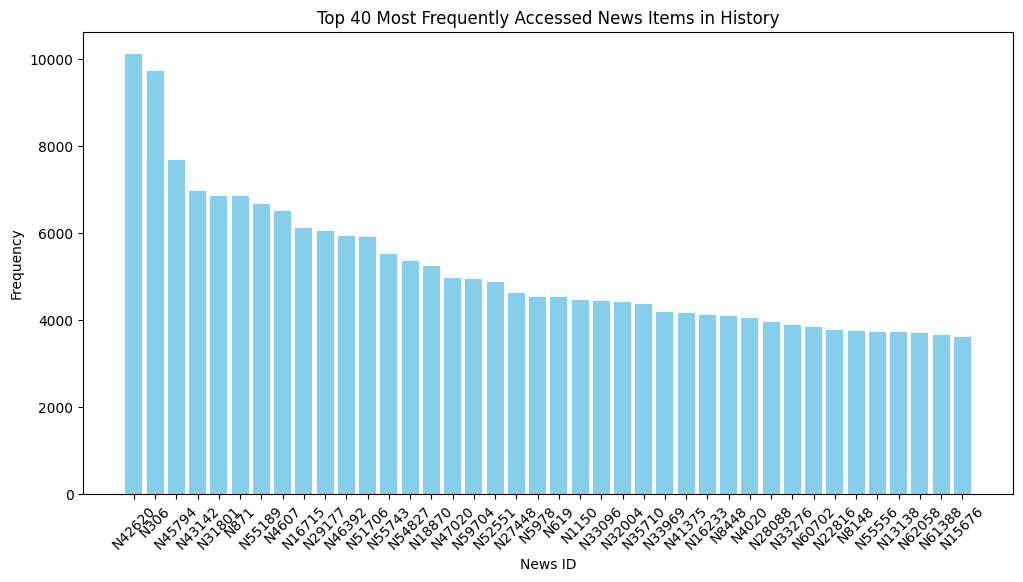

In [13]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import requests
import os
import networkx as nx
# 将所有历史点击合并到一个列表中
all_history = [news_id for sublist in behavior_data['history_list'] for news_id in sublist]

# 计算每个新闻ID的频率
news_frequency = Counter(all_history)

# 将频率数据转换为DataFrame进行排序和可视化
news_freq_df = pd.DataFrame(news_frequency.items(), columns=['News ID', 'Frequency'])
news_freq_df = news_freq_df.sort_values(by='Frequency', ascending=False)

# 显示最常被点击的前10条新闻
print(news_freq_df.head(10))

# 可视化最常被点击的新闻ID
plt.figure(figsize=(12, 6))
plt.bar(news_freq_df['News ID'].head(40), news_freq_df['Frequency'].head(40), color='skyblue')
plt.xlabel('News ID')
plt.ylabel('Frequency')
plt.title('Top 40 Most Frequently Accessed News Items in History')
plt.xticks(rotation=45)
plt.show()

   history_categories  Frequency
2                news      63211
0           lifestyle      50534
11             sports      46870
7                  tv      46838
6             finance      43973
3              health      34748
13       foodanddrink      34728
5              movies      34424
9               music      28909
1       entertainment      28819


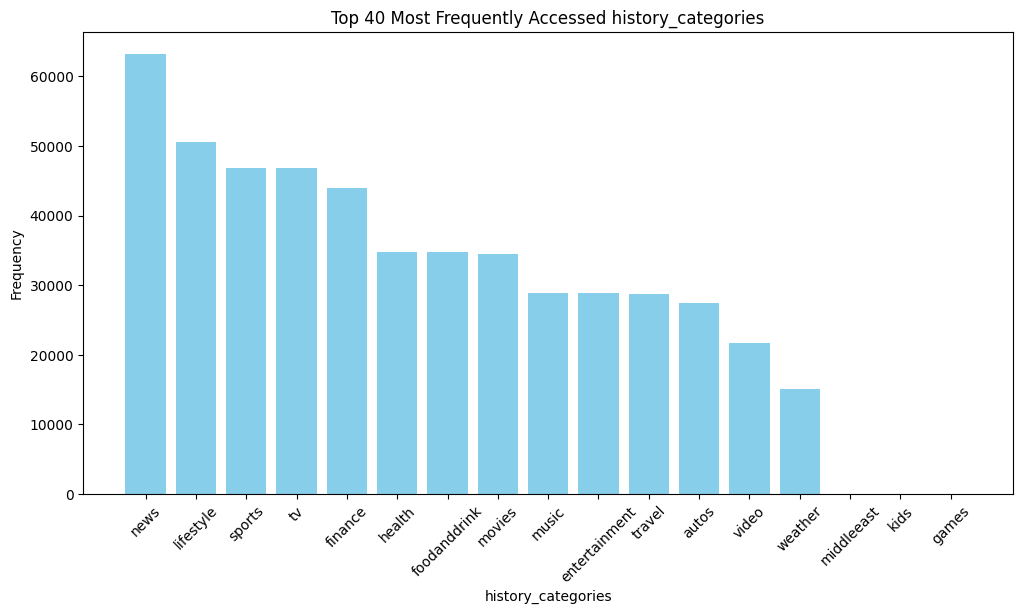

In [14]:
# 将所有历史点击合并到一个列表中
all_history = [news_id for sublist in behavior_data['history_categories'] for news_id in sublist]

# 计算每个新闻ID的频率
news_frequency = Counter(all_history)

# 将频率数据转换为DataFrame进行排序和可视化
news_freq_df = pd.DataFrame(news_frequency.items(), columns=['history_categories', 'Frequency'])
news_freq_df = news_freq_df.sort_values(by='Frequency', ascending=False)

# 显示最常被点击的前10条新闻
print(news_freq_df.head(10))

# 可视化最常被点击的新闻ID
plt.figure(figsize=(12, 6))
plt.bar(news_freq_df['history_categories'].head(40), news_freq_df['Frequency'].head(40), color='skyblue')
plt.xlabel('history_categories')
plt.ylabel('Frequency')
plt.title('Top 40 Most Frequently Accessed history_categories')
plt.xticks(rotation=45)
plt.show()

   impressions_categories  Frequency
2                    news      21067
0                  sports      17193
1               lifestyle      16559
8            foodanddrink       5982
9                      tv       5220
3                  health       3973
6                 finance       3657
5                   music       3589
11                 movies       3188
10                  autos       2574


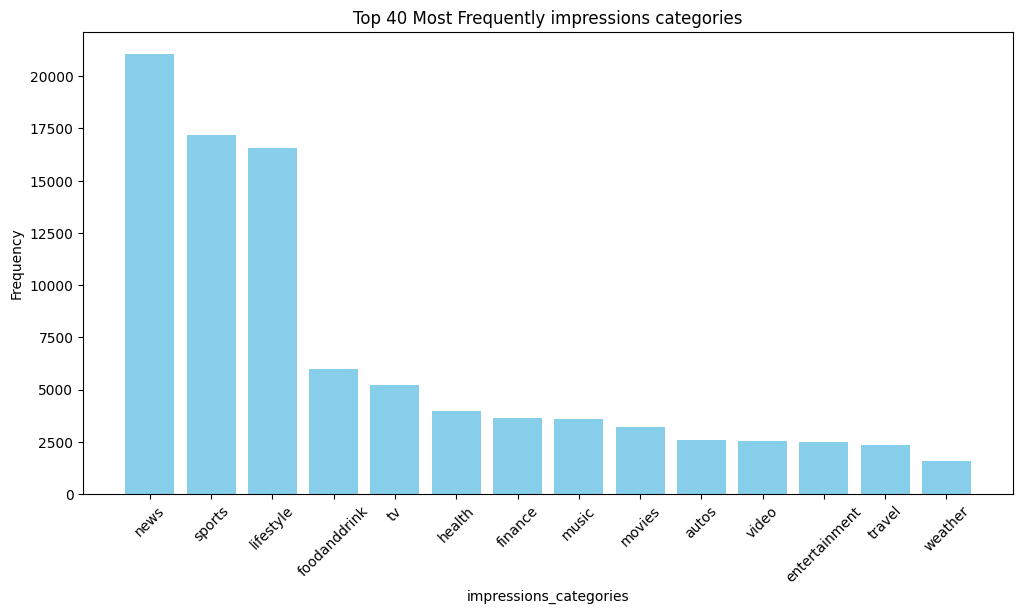

In [15]:
# 将所有历史点击合并到一个列表中
all_history = [news_id for sublist in behavior_data['impressions_categories'] for news_id in sublist]

# 计算每个新闻ID的频率
news_frequency = Counter(all_history)

# 将频率数据转换为DataFrame进行排序和可视化
news_freq_df = pd.DataFrame(news_frequency.items(), columns=['impressions_categories', 'Frequency'])
news_freq_df = news_freq_df.sort_values(by='Frequency', ascending=False)

# 显示最常被点击的前10条新闻
print(news_freq_df.head(10))

# 可视化最常被点击的新闻ID
plt.figure(figsize=(12, 6))
plt.bar(news_freq_df['impressions_categories'].head(40), news_freq_df['Frequency'].head(40), color='skyblue')
plt.xlabel('impressions_categories')
plt.ylabel('Frequency')
plt.title('Top 40 Most Frequently impressions categories')
plt.xticks(rotation=45)
plt.show()

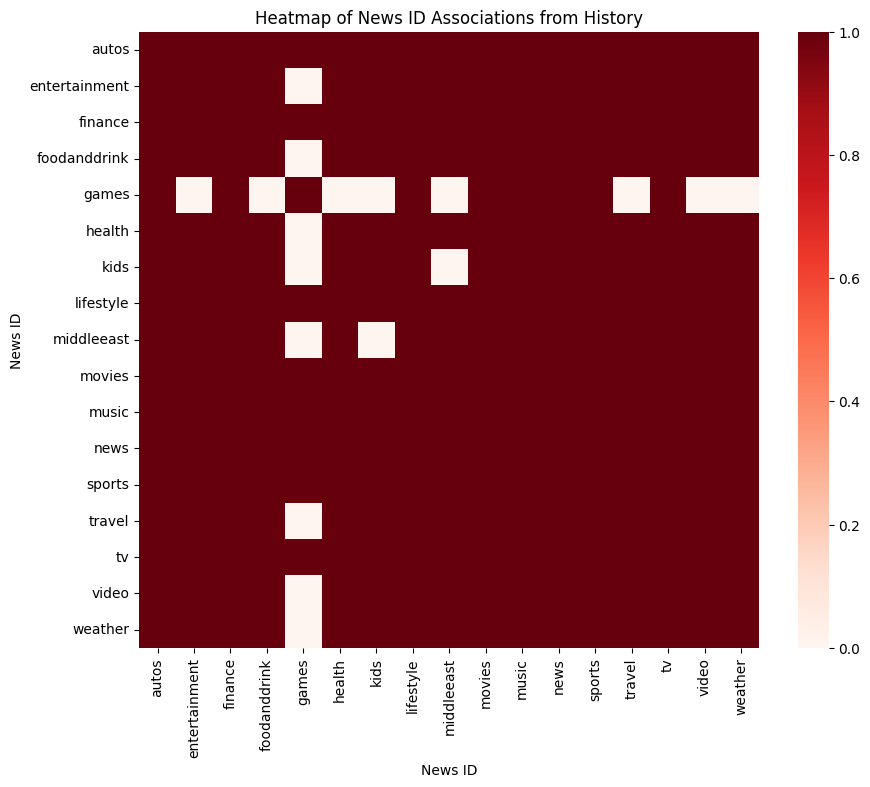

In [18]:
import numpy as np
# 从 TransactionEncoder 的结果构建关联矩阵
assoc_matrix = np.dot(te_categories.T, te_categories)
np.fill_diagonal(assoc_matrix, 1)  # 将对角线元素设置为0，避免自关联影响可视化效果

# 将关联矩阵转换为 DataFrame
assoc_matrix_df = pd.DataFrame(assoc_matrix, index=te.columns_, columns=te.columns_)

# 创建热图
plt.figure(figsize=(10, 8))
sns.heatmap(assoc_matrix_df, annot=False, cmap='Reds', xticklabels=True, yticklabels=True)
plt.title('Heatmap of News ID Associations from History')
plt.xlabel('News ID')
plt.ylabel('News ID')
plt.show()